In [1]:
from Propagation import *

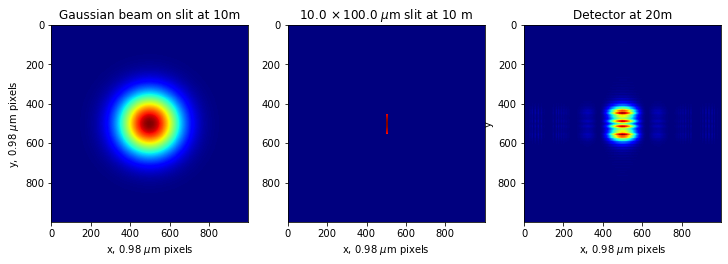

In [2]:
# Gaussian beam, 10m slit, 20m detector
''' Parameters '''
# Gaussian beam
E = 9500
omega = E/hbar
wavelength = 2*np.pi*c/omega
k = omega/c

w0x = 2e-6
w0y = 2e-6
N = 1000

# slit
slit_z = 10
slit_x = 1e1    # um
slit_y = 1e2    # um

# detector
det_z = 20

''' Propagation '''
beam_gaus,x,y = Gaussian_source(E,w0x,w0y,N,slit_z)
beam_slit = Slit(beam_gaus,x,y,slit_x,slit_y)
beam_det = Drift(beam_slit,x,y,wavelength,det_z-slit_z)

''' Plot '''
dx = x[0,1] - x[0,0]
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(Ibeam(beam_gaus),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title('Gaussian beam on slit at {}m'.format(slit_z))

plt.subplot(1,3,2)
plt.imshow(Ibeam(beam_slit),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title(r'{}$\,\times${} $\mu$m slit at {} m'.format(slit_x,slit_y,slit_z))

# plot drift
plt.subplot(1,3,3)
plt.imshow(Ibeam(beam_det),cmap='jet')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('detector {}m away'.format(detz-slitz))
plt.title('Detector at {}m'.format(det_z))
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.savefig('Gaussian_Beam_and_Slit_{}-{}.png'.format(slit_z,det_z),transparent=True)

# Work in progress

The following code can not be trusted yet.

[[-0.91349791+0.40684341j -0.06665892+0.99777582j  0.8755278 +0.48316775j
  ...  0.77938686-0.62654299j  0.8755278 +0.48316775j
  -0.06665892+0.99777582j]
 [-0.06665892+0.99777582j  0.85126097+0.52474256j  0.83601144-0.54871201j
  ... -0.19023885-0.98173784j  0.83601144-0.54871201j
   0.85126097+0.52474256j]
 [ 0.8755278 +0.48316775j  0.83601144-0.54871201j -0.14277244-0.98975554j
  ... -0.96985643-0.24367707j -0.14277244-0.98975554j
   0.83601144-0.54871201j]
 ...
 [ 0.77938686-0.62654299j -0.19023885-0.98173784j -0.96985643-0.24367707j
  ... -0.59363857+0.80473179j -0.96985643-0.24367707j
  -0.19023885-0.98173784j]
 [ 0.8755278 +0.48316775j  0.83601144-0.54871201j -0.14277244-0.98975554j
  ... -0.96985643-0.24367707j -0.14277244-0.98975554j
   0.83601144-0.54871201j]
 [-0.06665892+0.99777582j  0.85126097+0.52474256j  0.83601144-0.54871201j
  ... -0.19023885-0.98173784j  0.83601144-0.54871201j
   0.85126097+0.52474256j]]


Text(0.5, 1.0, 'detector, zoom in')

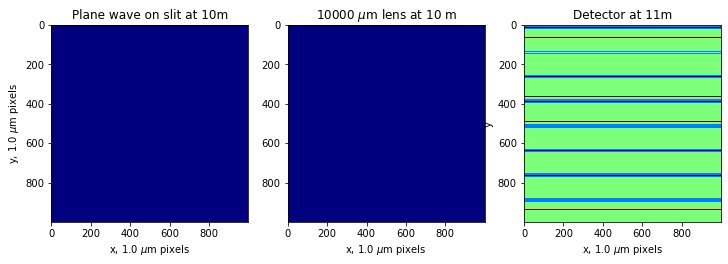

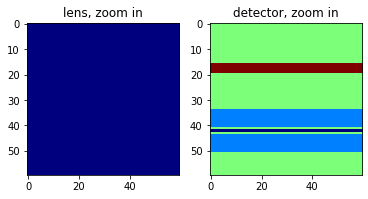

In [80]:
# Plane wave, 10m lens, focal plane detector
def Plane_source(E,z0,N=1000,dx=1e-6):
    omega = E/hbar
    wavelength = 2*np.pi*c/omega
    k = omega/c
    x = np.linspace(-N/2,N/2-1,N) * dx
    x,y = np.meshgrid(x,x)
    beam = np.ones(x.shape) * np.exp(-1j * k * z0)
    return beam, x, y

def Lens(beam,x,y,k,r,f):
    window = window = np.square(x)+np.square(y)<np.square(r/1e6)
    if window.sum() < window.size:
        print('lens aperture smaller than beam')
    transmission = np.exp(-1j * k/2/f * (np.square(x)+np.square(y)))
    print(transmission)
    T = NFFT(transmission)
    G = NFFT(beam)
    G = G*T
    beam_lens = INFFT(G)
    
    #phase = f * (1-np.cos(np.arcsin(np.sqrt(np.square(x)+np.square(y))/f)))
    #beam_lens = beam * window * np.exp(1j*phase)
    return beam_lens

# Plane wave
E = 9500
omega = E/hbar
wavelength = 2*np.pi*c/omega
k = omega/c

# lens
lens_z = 10
r = 10000       # um
f = 1
n = 1

# detector
det_z = lens_z+f

''' Propagation '''
beam_plane,x,y = Plane_source(E,lens_z)
beam_lens = Lens(beam_plane,x,y,k,r,f)
beam_det = Drift(beam_lens,x,y,wavelength,det_z-lens_z)

''' Plot '''
dx = x[0,1] - x[0,0]
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(Ibeam(beam_plane),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title('Plane wave on slit at {}m'.format(slit_z))

plt.subplot(1,3,2)
plt.imshow(Ibeam(beam_lens),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title(r'{} $\mu$m lens at {} m'.format(r,lens_z))

# plot drift
plt.subplot(1,3,3)
plt.imshow(Ibeam(beam_det),cmap='jet')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('detector {}m away'.format(detz-slitz))
plt.title('Detector at {}m'.format(det_z))
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.savefig('Gaussian_Beam_and_lens_{}-{}.png'.format(lens_z,det_z),transparent=True)

plt.figure()
plt.subplot(1,2,1)
plt.title('lens, zoom in')
plt.imshow(Ibeam(beam_lens)[470:530,470:530],cmap='jet')
plt.subplot(1,2,2)
plt.imshow(Ibeam(beam_det)[470:530,470:530],cmap='jet')
plt.title('detector, zoom in')

lens aperture smaller than beam


Text(0.5, 1.0, 'detector, zoom in')

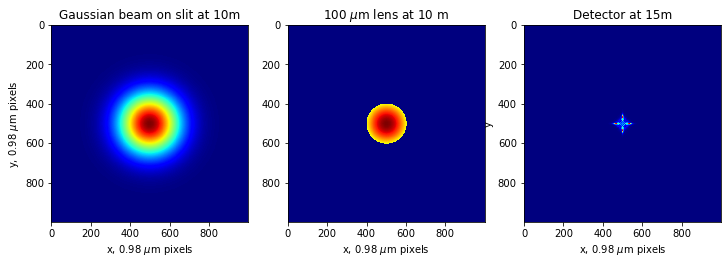

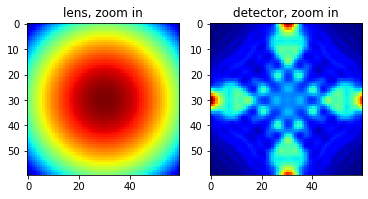

In [62]:
# Gaussian beam, 10m lens, focal plane detector
''' Parameters '''
# Gaussian beam
E = 9500
omega = E/hbar
wavelength = 2*np.pi*c/omega
k = omega/c

w0x = 2e-6
w0y = 2e-6
N = 1000

# lens
lens_z = 10
r = 100       # um
f = 5
n = 1

# detector
det_z = lens_z+f

''' Propagation '''
beam_gaus,x,y = Gaussian_source(E,w0x,w0y,N,lens_z)
beam_lens = Lens(beam_gaus,x,y,k,r,f,n)
beam_det = Drift(beam_lens,x,y,wavelength,det_z-lens_z)

''' Plot '''
dx = x[0,1] - x[0,0]
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(Ibeam(beam_gaus),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.ylabel('y, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title('Gaussian beam on slit at {}m'.format(slit_z))

plt.subplot(1,3,2)
plt.imshow(Ibeam(beam_lens),cmap='jet')
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.title(r'{} $\mu$m lens at {} m'.format(r,lens_z))

# plot drift
plt.subplot(1,3,3)
plt.imshow(Ibeam(beam_det),cmap='jet')
#plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
#plt.title('detector {}m away'.format(detz-slitz))
plt.title('Detector at {}m'.format(det_z))
plt.xlabel('x, {} $\mu$m pixels'.format(round(dx*1e6,3)))
plt.savefig('Gaussian_Beam_and_lens_{}-{}.png'.format(lens_z,det_z),transparent=True)

plt.figure()
plt.subplot(1,2,1)
plt.title('lens, zoom in')
plt.imshow(Ibeam(beam_lens)[470:530,470:530],cmap='jet')
plt.subplot(1,2,2)
plt.imshow(Ibeam(beam_det)[470:530,470:530],cmap='jet')
plt.title('detector, zoom in')

In [4]:
# curved mirrors
''' this is really hard to code up.... '''

' this is really hard to code up.... '